In [12]:
# Import TensorFlow
import tensorflow as tf 
print('tensorflow version', tf.__version__)

tensorflow version 2.2.0


In [13]:
# Cek resources GPU yang tersedia
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17461845077157488570
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2809232408916645755
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1440536987
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5681181315593323095
physical_device_desc: "device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10370272919378736514
physical_device_desc: "device: XLA_GPU device"
]
Num GPUs Available:  1


In [14]:
# Import library yang diperlukan
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_preprocessing
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import preprocess_input


In [15]:
# Load datasets
TRAIN_DIR = r"datasets\dermnet v2\train"
VAL_DIR = r"datasets\dermnet v2\test"
class_list = os.listdir(r"datasets\dermnet v2\train")

## Preprocess data
num_class = len(class_list)
img_height, img_width = 118, 180
IMG_SHAPE = (img_height, img_width, 3)

BATCH_SIZE = 32

# Augmentasi data
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rescale=1./255,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(img_height, img_width), 
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')
                                            
test_datagen =  ImageDataGenerator(rescale=1./255,)

validation_generator = test_datagen.flow_from_directory(VAL_DIR, 
                                                        target_size=(img_height, img_width), 
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Found 5236 images belonging to 7 classes.
Found 1339 images belonging to 7 classes.


In [16]:
# Model Machine Learning
VGG16_MODEL = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                          include_top=False,
                                          weights='imagenet')
for layer in VGG16_MODEL.layers:
    layer.trainable = False

output = VGG16_MODEL.output
output = tf.keras.layers.GlobalMaxPooling2D()(output)

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

dropout = 0.1

x = layers.Flatten()(output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(num_class, activation='softmax')(x)

model = Model(VGG16_MODEL.input, x)

loss = 'categorical_crossentropy'
metrics = ['accuracy']
do_fine_tuning = False

if do_fine_tuning:
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer = optimizer,  loss = loss, metrics = metrics)

model.call = tf.function(model.call)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 118, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 118, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 118, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 59, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 59, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 59, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 29, 45, 128)       0   

In [17]:
# Fungsi Callbacks
class Callbacks(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(Callbacks, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

my_callback = Callbacks(threshold=0.9)

In [18]:
# Train Model
NUM_EPOCHS = 60
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            validation_steps = validation_generator.samples//BATCH_SIZE,
            steps_per_epoch = train_generator.samples//BATCH_SIZE,
            epochs = NUM_EPOCHS,
            verbose = 1,
            callbacks=[my_callback])

Epoch 1/60
163/163 [==============================] - 89s 545ms/step - loss: 1.5475 - accuracy: 0.3766 - val_loss: 1.5903 - val_accuracy: 0.3811
Epoch 2/60
163/163 [==============================] - 89s 545ms/step - loss: 1.4119 - accuracy: 0.4274 - val_loss: 1.5329 - val_accuracy: 0.3864
Epoch 3/60
163/163 [==============================] - 89s 544ms/step - loss: 1.3596 - accuracy: 0.4516 - val_loss: 1.6147 - val_accuracy: 0.4123
Epoch 4/60
163/163 [==============================] - 89s 546ms/step - loss: 1.3326 - accuracy: 0.4564 - val_loss: 1.5445 - val_accuracy: 0.4047
Epoch 5/60
163/163 [==============================] - 89s 546ms/step - loss: 1.2891 - accuracy: 0.4841 - val_loss: 1.6512 - val_accuracy: 0.3651
Epoch 6/60
163/163 [==============================] - 88s 539ms/step - loss: 1.2789 - accuracy: 0.4906 - val_loss: 1.6015 - val_accuracy: 0.4207
Epoch 7/60
163/163 [==============================] - 88s 539ms/step - loss: 1.2781 - accuracy: 0.4800 - val_loss: 1.5497 - val_ac

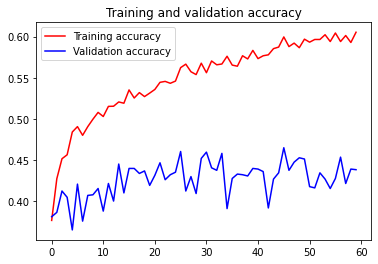

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot accuracy hasil training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [20]:
# Grad-CAM untuk melakukan highlight fitur yang dideteksi Model
# Acknowledgement:
# Grad-CAM code by: Adrian Rosebrock, PhD (2020)
# https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output.shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(inputs= [self.model.inputs], 
                          outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)

Hasil Prediksi:
Kemungkinan 57.05% penyakit Acne
Kemungkinan 17.48% penyakit Dermatitis
Kemungkinan 12.82% penyakit Fungal Infections


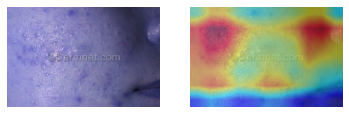

In [21]:
# Prediksi
input_path = r'datasets\dermnet v2\test\Acne\acne-closed-comedo-2.jpg'
image = cv2.imread(input_path)
image = cv2.resize(image, (img_width, img_height))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
             
preds = model.predict(image)
sorting = (-preds).argsort()
sorted_ = sorting[0][:3]

print("Hasil Prediksi:")
for value in sorted_:
    predicted_label = class_list[value]
    prob = (preds[0][value]) * 100
    prob = "%.2f" % round(prob,2)
    print("Kemungkinan %s%% penyakit %s" % (prob, predicted_label))

i = np.argmax(preds[0])
icam = GradCAM(model, i, 'block5_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (img_width, img_height))

image = cv2.imread(input_path)
image = cv2.resize(image, (img_width, img_height))

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
_ = ax[0].axis('off')
ax[1].imshow(output)
_ = ax[1].axis('off')

In [23]:
# Simpan Model
save_path = os.path.join(r"D:\SkinDet\\", r"skindetmodel/v1.2/")
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: D:\SkinDet\\skindetmodel/v1.2/assets
